In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json
/kaggle/input/sarcasmdetectionprocessed/SarcasmDetectionProcessed.csv


In [59]:
import pandas as pd
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix, plot_confusion_matrix
from numpy import argmax
import seaborn as sns

datastore = pd.read_csv('../input/sarcasmdetectionprocessed/SarcasmDetectionProcessed.csv')

sentences = datastore['Tweet'].tolist()
labels = datastore['Label'].tolist()

#shuffle data to split into train, test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, train_size = 0.8, random_state = 42, shuffle = True)

In [14]:
len(datastore)

65067

In [13]:
print(datastore.shape)
train_dataframe = datastore[0:52053]
test_dataframe = datastore[52053:65067]

(65067, 3)


In [15]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

52053
52053
13014
13014


In [60]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
def cm(y_pred):
    y_true = testing_labels
    target_names = ['class 0', 'class 1']
    print(classification_report(y_true, y_pred, target_names=target_names))

    cm = confusion_matrix(y_true, y_pred)
    f = sns.heatmap(cm, annot=True, fmt='d')
    
def roc(probs):
    preds = probs[:,0]
    fpr, tpr, threshold = metrics.roc_curve(testing_labels, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [16]:
#tokenize text
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
embedding_dim = 16
max_length = 100
training_size = 20000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,maxlen=max_length, padding='post', truncating='post')

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding='post', truncating='post')

In [18]:
training_padded = np.array(training_padded)
training_labels = np.array(y_train)
testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes = 1),  tf.keras.metrics.AUC()]
#callbacks
checkpoint = ModelCheckpoint('SarcasmTF.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.001)
callbacks = [earlystop, checkpoint, learning_rate_reduction]

model.compile(loss='binary_crossentropy',optimizer='adam',metrics = metrics)
history = model.fit(training_padded, training_labels, epochs=30, validation_data=(testing_padded, testing_labels), callbacks = callbacks)

Epoch 1/30
1627/1627 [==============================] - 8s 4ms/step - loss: 0.4806 - accuracy: 0.7451 - precision: 0.5647 - recall: 0.5011 - f1_score: 0.5018 - auc: 0.7782 - val_loss: 0.3246 - val_accuracy: 0.8342 - val_precision: 0.6679 - val_recall: 0.9881 - val_f1_score: 0.4958 - val_auc: 0.8837

Epoch 00001: val_loss improved from inf to 0.32458, saving model to SarcasmTF.h5
Epoch 2/30
1627/1627 [==============================] - 6s 4ms/step - loss: 0.3308 - accuracy: 0.8291 - precision: 0.6670 - recall: 0.9793 - f1_score: 0.5021 - auc: 0.8753 - val_loss: 0.3285 - val_accuracy: 0.8314 - val_precision: 0.6693 - val_recall: 0.9655 - val_f1_score: 0.4958 - val_auc: 0.8721

Epoch 00002: val_loss did not improve from 0.32458
Epoch 3/30
1627/1627 [==============================] - 6s 4ms/step - loss: 0.3274 - accuracy: 0.8299 - precision: 0.6676 - recall: 0.9791 - f1_score: 0.5010 - auc: 0.8836 - val_loss: 0.3337 - val_accuracy: 0.8302 - val_precision: 0.6693 - val_recall: 0.9580 - val_f

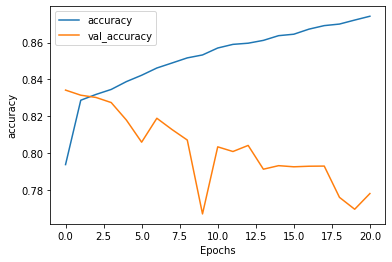

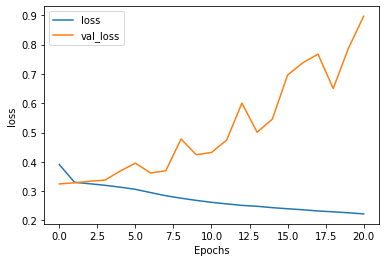

In [19]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Epoch 1/30
1627/1627 [==============================] - 16s 9ms/step - loss: 0.4519 - accuracy: 0.7624 - precision_1: 0.5960 - recall_1: 0.5883 - f1_score: 0.5024 - auc_1: 0.8112 - val_loss: 0.3221 - val_accuracy: 0.8359 - val_precision_1: 0.6711 - val_recall_1: 0.9851 - val_f1_score: 0.4958 - val_auc_1: 0.8757

Epoch 00001: val_loss improved from inf to 0.32210, saving model to SarcasmCNN.h5
Epoch 2/30
1627/1627 [==============================] - 14s 9ms/step - loss: 0.3254 - accuracy: 0.8313 - precision_1: 0.6667 - recall_1: 0.9887 - f1_score: 0.5004 - auc_1: 0.8830 - val_loss: 0.3246 - val_accuracy: 0.8357 - val_precision_1: 0.6713 - val_recall_1: 0.9827 - val_f1_score: 0.4958 - val_auc_1: 0.8735

Epoch 00002: val_loss did not improve from 0.32210
Epoch 3/30
1627/1627 [==============================] - 14s 8ms/step - loss: 0.3224 - accuracy: 0.8281 - precision_1: 0.6600 - recall_1: 0.9904 - f1_score: 0.4972 - auc_1: 0.8939 - val_loss: 0.3318 - val_accuracy: 0.8336 - val_precision_1:

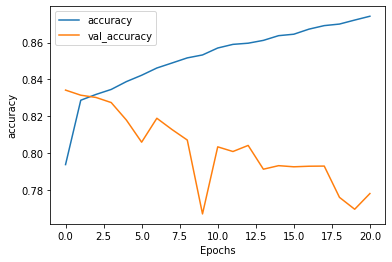

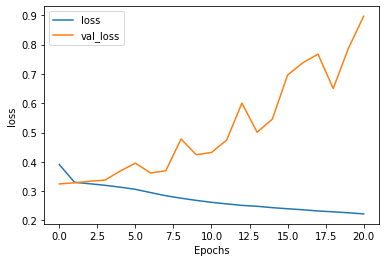

In [21]:
#CNN Model
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes = 1),  tf.keras.metrics.AUC()]
#callbacks
checkpoint = ModelCheckpoint('SarcasmCNN.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.001)
callbacks = [earlystop, checkpoint, learning_rate_reduction]

model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=metrics)
history1 = model1.fit(training_padded, training_labels, epochs=30, validation_data=(testing_padded, testing_labels), callbacks=callbacks)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

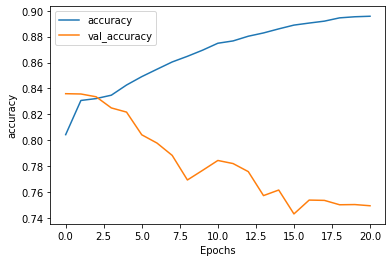

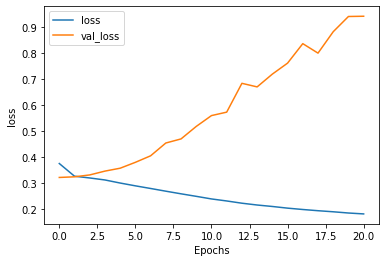

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     class 0       0.67      1.00      0.80      8725
     class 1       0.00      0.00      0.00      4289

    accuracy                           0.67     13014
   macro avg       0.34      0.50      0.40     13014
weighted avg       0.45      0.67      0.54     13014



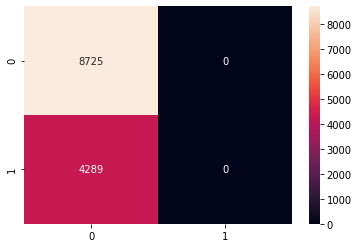

In [46]:
plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")
y_pred = argmax(model1.predict(testing_padded),axis=1)
cm(y_pred)

In [24]:
#LSTM model
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes = 1),  tf.keras.metrics.AUC()]
#callbacks
checkpoint = ModelCheckpoint('SarcasmLSTM.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.001)
callbacks = [earlystop, checkpoint, learning_rate_reduction]

model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=metrics)
history2 = model2.fit(training_padded, training_labels, epochs=30, validation_data=(testing_padded, testing_labels), callbacks=callbacks)

Epoch 1/30
1627/1627 [==============================] - 86s 50ms/step - loss: 0.4327 - accuracy: 0.7705 - precision_2: 0.6263 - recall_2: 0.6863 - f1_score: 0.5032 - auc_2: 0.8207 - val_loss: 0.3209 - val_accuracy: 0.8361 - val_precision_2: 0.6710 - val_recall_2: 0.9862 - val_f1_score: 0.4958 - val_auc_2: 0.8754

Epoch 00001: val_loss improved from inf to 0.32091, saving model to SarcasmLSTM.h5
Epoch 2/30
1627/1627 [==============================] - 82s 51ms/step - loss: 0.3244 - accuracy: 0.8309 - precision_2: 0.6664 - recall_2: 0.9866 - f1_score: 0.4999 - auc_2: 0.8864 - val_loss: 0.3229 - val_accuracy: 0.8356 - val_precision_2: 0.6703 - val_recall_2: 0.9862 - val_f1_score: 0.4958 - val_auc_2: 0.8743

Epoch 00002: val_loss did not improve from 0.32091
Epoch 3/30
1627/1627 [==============================] - 83s 51ms/step - loss: 0.3140 - accuracy: 0.8363 - precision_2: 0.6772 - recall_2: 0.9753 - f1_score: 0.5010 - auc_2: 0.9012 - val_loss: 0.3432 - val_accuracy: 0.8247 - val_precisio

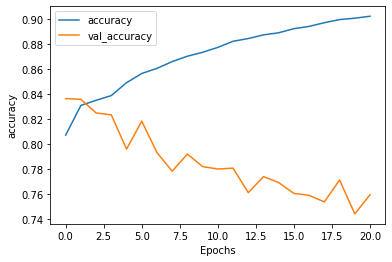

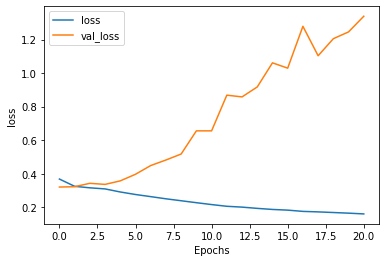

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     class 0       0.67      1.00      0.80      8725
     class 1       0.00      0.00      0.00      4289

    accuracy                           0.67     13014
   macro avg       0.34      0.50      0.40     13014
weighted avg       0.45      0.67      0.54     13014



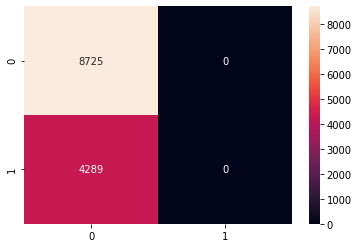

In [45]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")
y_pred = argmax(model2.predict(testing_padded),axis=1)
cm(y_pred)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


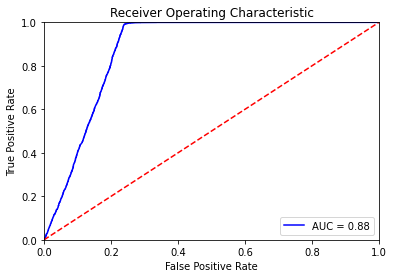

In [58]:
probs = model2.predict_proba(testing_padded)
roc(probs)

Epoch 1/10
1627/1627 [==============================] - 288s 168ms/step - loss: 5.1493 - accuracy: 0.6662 - val_loss: 5.0836 - val_accuracy: 0.6704

Epoch 00001: val_loss improved from inf to 5.08357, saving model to SarcasmRNN.h5
Epoch 2/10
1627/1627 [==============================] - 268s 165ms/step - loss: 5.1582 - accuracy: 0.6656 - val_loss: 5.0836 - val_accuracy: 0.6704

Epoch 00002: val_loss did not improve from 5.08357
Epoch 3/10
1627/1627 [==============================] - 269s 166ms/step - loss: 5.1782 - accuracy: 0.6643 - val_loss: 5.0836 - val_accuracy: 0.6704

Epoch 00003: val_loss did not improve from 5.08357
Epoch 4/10
1627/1627 [==============================] - 271s 167ms/step - loss: 5.1723 - accuracy: 0.6647 - val_loss: 5.0836 - val_accuracy: 0.6704

Epoch 00004: val_loss did not improve from 5.08357
Epoch 5/10
1627/1627 [==============================] - 269s 165ms/step - loss: 5.1840 - accuracy: 0.6639 - val_loss: 5.0836 - val_accuracy: 0.6704

Epoch 00005: val_los

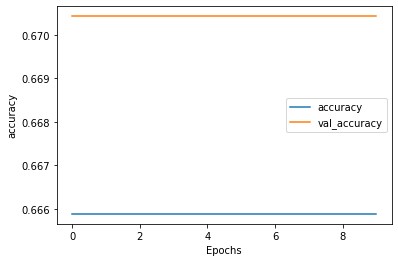

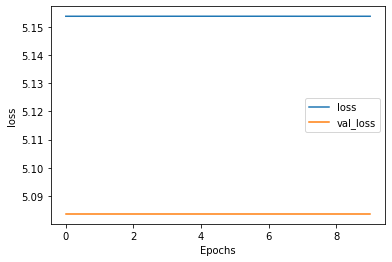

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engi

              precision    recall  f1-score   support

     class 0       0.67      1.00      0.80      8725
     class 1       0.00      0.00      0.00      4289

    accuracy                           0.67     13014
   macro avg       0.34      0.50      0.40     13014
weighted avg       0.45      0.67      0.54     13014



AttributeError: 'list' object has no attribute 'roc_curve'

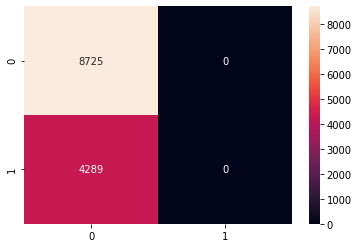

In [64]:
#RNN Model
# encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size)
# encoder.adapt((datastore['headline']).map(lambda text, label: text))
model3 = tf.keras.Sequential([
    #encoder,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),  tf.keras.metrics.AUC()]
#callbacks
checkpoint = ModelCheckpoint('SarcasmRNN.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.001)
callbacks = [earlystop, checkpoint, learning_rate_reduction]

model3.compile(loss='binary_crossentropy',optimizer='adam',metrics= ['accuracy'])
#model3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
history3 = model3.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels),  callbacks=callbacks)

plot_graphs(history3, "accuracy")
plot_graphs(history3, "loss")
y_pred = argmax(model3.predict(testing_padded),axis=1)
cm(y_pred)

probs = model2.predict_proba(testing_padded)
roc(probs)

In [71]:
# BERT
from transformers import BertTokenizer
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
def input_for_bert_model(df, tokenizer, max_seq_length):
    columns_list = df.columns.tolist()
    input_ids = np.zeros((len(df), max_seq_length))
    input_attention_masks = np.zeros((len(df), max_seq_length))
    
    if 'Label' in columns_list:
        train_labels = np.zeros((len(df), 1))
        for i, labels in enumerate(df['Label']):
            train_labels[i,:] = labels
    
    for i, sequence in enumerate(df['Tweet']):
        tokens = tokenizer.encode_plus(
            sequence,
            max_length = max_seq_length, # max length of the text that can go to BERT
            truncation=True, padding='max_length',
            add_special_tokens = True, # add [CLS], [SEP]
            return_token_type_ids = False, 
            return_attention_mask = True, # add attention mask to not focus on pad tokens
            return_tensors = 'tf'
        )
        input_ids[i,:], input_attention_masks[i,:] = tokens['input_ids'], tokens['attention_mask']
    
    if 'Label' in columns_list:
        return input_ids, input_attention_masks, train_labels
    else:
        return input_ids, input_attention_masks

In [75]:
train_ids, train_attention_masks, train_labels = input_for_bert_model(train_dataframe, bert_tokenizer, max_length)
test_ids, test_attention_masks, test_labels = input_for_bert_model(test_dataframe, bert_tokenizer, max_length)
train_inputs = {"input_ids":train_ids[:52053], "attention_mask":train_attention_masks[:52053]}
train_outputs = train_labels[:52053]
valid_inputs = {"input_ids":train_ids[52053:], "attention_mask":train_attention_masks[52053:]}
valid_outputs = train_labels[52053:]
test_inputs = {"input_ids":test_ids, "attention_mask":test_attention_masks}
test_outputs = test_labels[52053:]

In [73]:
#Bert model initialization
from transformers import BertTokenizer, TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")
sequence_output = bert_model(input_ids, attention_mask=attention_mask)[0][:,0,:]
x = tf.keras.layers.Dropout(0.1)(sequence_output)
out = tf.keras.layers.Dense(1, activation='linear', name="outputs")(x)
model4 = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=out)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),  tf.keras.metrics.AUC()]
model4.compile(optimizer=optimizer, loss='mean_squared_error', metrics= 'accuracy')

#callbacks
checkpoint = ModelCheckpoint('BERT_v2.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.001)
callbacks = [earlystop, checkpoint, learning_rate_reduction]
history4 = model4.fit(train_inputs, train_outputs, epochs=10, batch_size=8, validation_data=(valid_inputs, valid_outputs), callbacks=callbacks)

plot_graphs(history4, "accuracy")
plot_graphs(history4, "loss")
y_pred = argmax(model4.predict(testing_padded),axis=1)
cm(y_pred)
try:
    probs = model4.predict_proba(testing_padded)
    roc(probs)
    
except:
    pass

Epoch 1/10
   9/6507 [..............................] - ETA: 9:02:15 - loss: 0.6903 - accuracy: 0.5215

In [ ]:
#plotting comparison between 4 models
import pandas as pd
from pandas import DataFrame
accuracy = [max(history1.history['val_accuracy']),max(history2.history['val_accuracy']), max(history3.history['val_accuracy']),max(history4.history['val_accuracy'])]
loss = [max(history1.history['val_loss']),max(history2.history['val_loss']),max(history3.history['val_loss']),max(history4.history['val_loss'])]

col={'Accuracy':accuracy,'Loss':loss}
models=['NN','CNN','LSTM']
graph_df=DataFrame(data=col,index=models)
graph_df

In [ ]:
graph_df.plot(kind='bar')